# Simple Stock Back Test Demo

## Abstract

This is a simple demo for Chinese A-share market to do back test. The demo can help my lstm stock selection project to be tested back. Therefore, this stock return test is only applicable to the trading rules of Chinese A-share market.

In [1]:
'''
    Author： Lucius
    Data： 2020/09/04
    Editor: 0.0.1
'''
### Import some necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

print('Libraries success')

Libraries success


In [2]:
### Read the history data of chinese A-share market
his_data = pd.read_csv('./chuang_300_dataset/chuang_300_daily_price.csv').drop(columns=['Unnamed: 0']).sort_values(by=['time', 'code'])
# his_data['time'] = his_data['time'].astype('datetime64')
his_data.head()

,time,code,open,close,high,low,volume,money
82996,2015-01-05,300001.XSHE,8.35,8.80,9.22,7.83,26473159.0,229584640.0
179567,2015-01-05,300002.XSHE,10.85,11.02,11.06,10.60,30858271.0,334580064.0
123563,2015-01-05,300003.XSHE,11.61,11.19,11.64,11.16,14507313.0,162720816.0
278690,2015-01-05,300006.XSHE,7.88,7.79,7.90,7.70,4516757.0,35247628.0
51715,2015-01-05,300007.XSHE,14.12,13.84,14.20,13.30,2216605.0,30315350.0


In [9]:
### Create Stock Position, it include cash, shares, holding-cost, profit and growth rate.
class StockPosition:
    
    def __init__(self, INIT_CASH):
        self.cash = INIT_CASH   ## The remaining cash in the account
        self.sharePositions = []
    
    ## Obtain position information
    def getPositions(self, date):
        result = []
        for share in self.sharePositions:
            try:
                close = his_data[(his_data['time'] == date) & (his_data['code'] == share['code'])].close.values[0]
                item = {}
                item['code'] = share['code']
                item['hold'] = share['hold']
                item['cost'] = share['cost']
                item['value'] = share['hold'] * close
                item['profit'] = (share['hold'] * close) - (share['hold'] * share['cost'])
                result.append(item)
            except:
                pass
            
        return result
    
    ## Get the remaining cash in account
    def getCash(self):
        return self.cash
    
    ## Get the date of profit
    def getProfit(self, date):
        result = 0
        trade_date = date
        profits = self.getPositions(trade_date)
        for profit in profits:
            result += profit['profit']
    
        return result
    
    ## get the date of growthRate
    def getGrowthRate(self, date, INIT_CASH):
        trade_date = date
        positions = self.getPositions(trade_date)
        values = 0.0
        for position in positions:
            values += position['value']
        
        return ((values + self.cash - INIT_CASH) / INIT_CASH) * 100
    
    ## Update the positions
    def updatePosition(self, code, volumn, trade_type, price): ## trade_type: 1: 'buy', 0: 'sell'
        existedShares = self.sharePositions
        existedCode = False
        if existedShares:
            for share in existedShares:
                if share['code'] == code:
                    if trade_type == 1:
                        self.cash = self.cash - (price * volumn)
                        share['code'] = code
                        share['cost'] = ((share['cost'] * share['hold']) + (price * volumn)) / (share['hold'] + volumn)
                        share['hold'] += volumn
                    else:
                        self.cash = self.cash + (price * volumn)
                        share['hold'] -= volumn
                    existedCode = True
        else:
            item = {}
            if trade_type == 1:
                self.cash = self.cash - (price * volumn)
                item['code'] = code
                item['cost'] = price
                item['hold'] = volumn
                existedShares.append(item)
                self.sharePositions = existedShares
                existedCode = True
    
        if not existedCode:
            item = {}
            if trade_type == 1:
                self.cash = self.cash - (price * volumn)
                item['code'] = code
                item['cost'] = price
                item['hold'] = volumn
                existedShares.append(item)
                self.sharePositions = existedShares
            
        
        return self.sharePositions
    
        

In [4]:
## Create the class of trade, the trade class is used for trade shares
'''
    strategy: 1:open price sell or buy, 0:close price sell or buy
    trade_type: 1.buy 0.sell
'''
class Trade:
    def __init__(self, TRADE_FEE, MINI_FEE, TAX_FEE, T):
        self.tradeRecord = []
        self.tradeFee = TRADE_FEE
        self.rule = T
        self.miniFee = MINI_FEE
        self.taxFee = TAX_FEE
        
    def getActiveShares(self, code, date, shares):  ## Get the stocks that can be traded according to the trading rules
        curDate = datetime.datetime.strptime(date, "%Y-%m-%d")
        activeShares = shares
        for trade in self.tradeRecord:
            if trade['code'] == code and trade['trade_type'] == 1:
                trade_date = datetime.datetime.strptime(trade['date'], "%Y-%m-%d")
                activeDate = trade_date + datetime.timedelta(days = self.rule)
                if curDate < activeDate:
                    print('curDate:', curDate, 'activeDate:', activeDate)
                    activeShares -= trade['volumn']
        
        return activeShares
                
        
    def buy_cash(self, code, date, item_cash, strategy):
        item = {}
        price = 0.0
        cost = 0.0
        if strategy == 1:
            price = his_data[(his_data['time'] == date) & (his_data['code'] == code)].open.values[0]
        else:
            price = his_data[(his_data['time'] == date) & (his_data['code'] == code)].close.values[0]
        volumn = int((item_cash / price) / 100) * 100
        if volumn == 0:
            return False
        else:
            if (volumn * price) * self.tradeFee <= 5:
                cost = (volumn * price) + MINI_FEE
            else:
                cost = (volumn * price) * (1 + self.tradeFee + self.taxFee)
            item['code'] = code
            item['date'] = date
            item['price'] = cost / volumn
            item['volumn'] = volumn
            item['trade_type'] = 1

            self.tradeRecord.append(item)
            return item
    
    def buy_volumn(self, code, date, volumn, strategy, remainingCash):
        item = {}
        price = 0.0
        cost = 0.0
        if strategy == 1:
            price = his_data[(his_data['time'] == date) & (his_data['code'] == code)].open.values[0]
        else:
            price = his_data[(his_data['time'] == date) & (his_data['code'] == code)].close.values[0]
        if remainingCash >= (price * volumn):
            if (volumn * price) * self.tradeFee <= 5:
                cost = (volumn * price) + MINI_FEE
            else:
                cost = (volumn * price) * (1 + self.tradeFee + self.taxFee)
            item['code'] = code
            item['date'] = date
            item['price'] = cost / volumn
            item['volumn'] = volumn
            item['trade_type'] = 1
            
            self.tradeRecord.append(item)
            return item
        else:
            return False
        
    def sell(self, code, date, precent, strategy, shares):
        item = {}
        price = 0.0
        activeShares = self.getActiveShares(code, date, shares)
        # print('date:',date,activeShares)
        if activeShares == 0:
            return False
        else:
            if strategy == 1:
                price = his_data[(his_data['time'] == date) & (his_data['code'] == code)].open.values[0]
            else:
                price = his_data[(his_data['time'] == date) & (his_data['code'] == code)].close.values[0]
            item['code'] = code
            item['date'] = date
            item['price'] = price
            item['volumn'] = int(activeShares * precent)
            item['trade_type'] = 0

            self.tradeRecord.append(item)
        return item
    
    def getTradeRecord(self):
        
        return self.tradeRecord

In [5]:
def visualization(x_dataset, y_datasets):
    plt.figure(figsize=(26, 12))
    plt.title("Rate of Return")
    for y_dataset in y_datasets:
        plt.plot(x_dataset, y_dataset, linewidth=2.0, label="Strategic rate of return")
        
    plt.legend()
    plt.show()

In [6]:
## Market rules and transaction fee setting
INIT_CASH = 1000000 ## Initial trading account amount
TRADE_FEE = 0.003 ## Trading cost
TAX_FEE = 0.001 ## The tax of one sell trading order
MINI_FEE = 5 ## The smallest of a trade
T = 1 ## Trading rule, T+1: If you buy a company's shares today, but you should sell it in T+1 days, you can't sell it today

In [7]:
## The strategy of trading, How to make a deal
def strategy(trade_date_list, codes):
    stockPosition = StockPosition(INIT_CASH)
    trade = Trade(TRADE_FEE, MINI_FEE, TAX_FEE, T)
    returnRate = []
    for date in trade_date_list:
        ### Sell strategy
        '''
        positions = stockPosition.getPositions(date)
        if positions:
            for share in positions:
                trade_item = trade.sell(share['code'], date, 1, 1, share['hold'])
                if trade_item:
                    stockPosition_info = stockPosition.updatePosition(trade_item['code'], trade_item['volumn'], trade_item['trade_type'], trade_item['price'])
        '''
        ### Buy strategy
        cash = stockPosition.getCash()
        if cash > 0:
            item_cash = cash / len(codes)
            for code in codes:
                trade_item = trade.buy_cash(code, date, item_cash, 1)
                if trade_item:
                    stockPosition_info = stockPosition.updatePosition(trade_item['code'], trade_item['volumn'], trade_item['trade_type'], trade_item['price'])
                
        returnRate.append(stockPosition.getGrowthRate(date, INIT_CASH))
        
        # print('date:', date, stockPosition.getPositions(date))
    # print('date:', date, trade.getTradeRecord())
    return returnRate
    

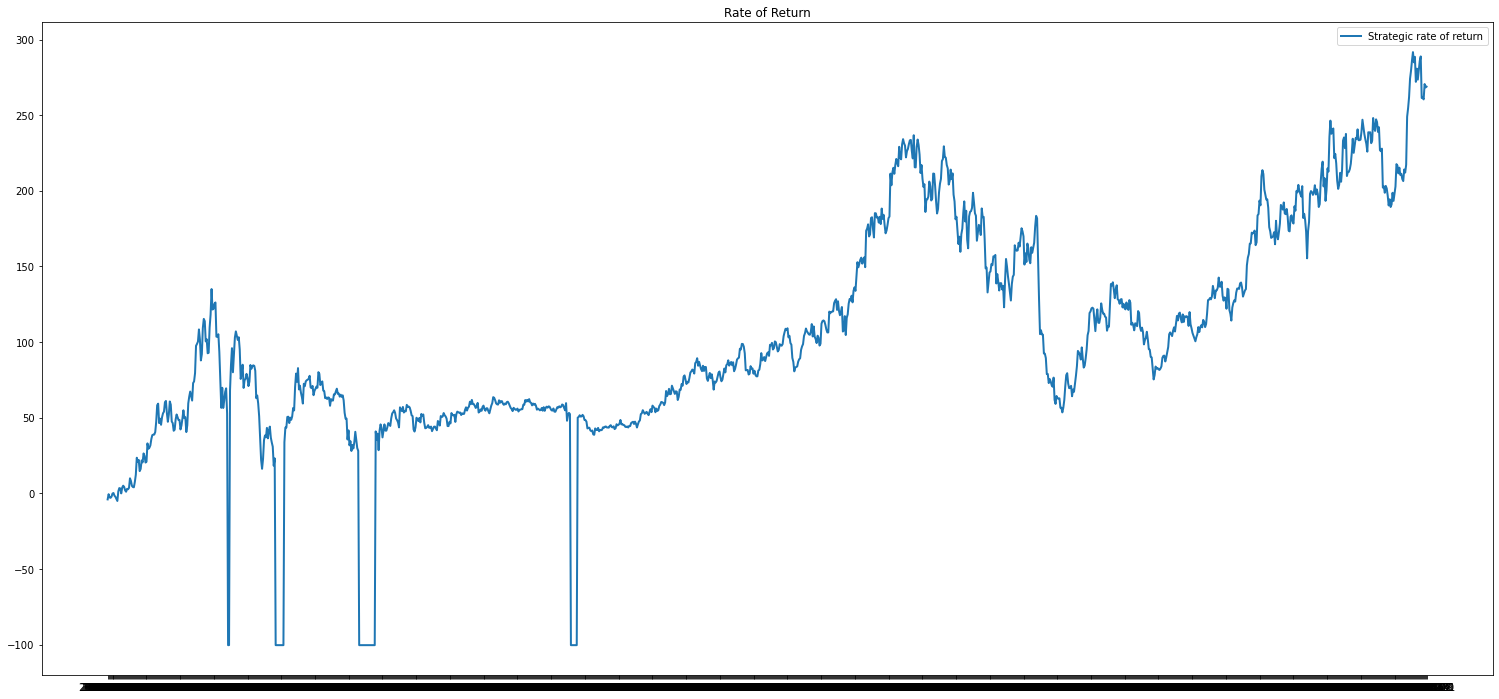

In [10]:

# def __init__(self, TRADE_FEE, MINI_FEE, T):

trade_date_list = his_data['time'].drop_duplicates(keep='first').values ## The date range of test return
stock_list = ['300003.XSHE']  ## The stock's pool

y_datasets = []

strategyReturn = strategy(trade_date_list, stock_list)
y_datasets.append(strategyReturn)

visualization(trade_date_list, y_datasets) ## visualization of strategy
